In [7]:
"""
Text Analytics using NLP for analysis of Citation Listing

Also some example code for graphing nodes & edge data

Recommended dataset by Professor Zhang
DBLP collaboration network and ground-truth communities
-------------------------------------------------------
- https://snap.stanford.edu/data/com-DBLP.html
  data/com-dblp.ungraph.txt
  data/com-dblp.all.cmty.txt
  
Movie recommender tutorial - with some NLP analytics  
https://www.datacamp.com/community/tutorials/recommender-systems-python  
"""
#!pip3 install snap-stanford
#!pip3 install wordcloud

'\nText Analytics using NLP for analysis of Citation Listing\n\nAlso some example code for graphing nodes & edge data\n\nRecommended dataset by Professor Zhang\nDBLP collaboration network and ground-truth communities\n-------------------------------------------------------\n- https://snap.stanford.edu/data/com-DBLP.html\n  data/com-dblp.ungraph.txt\n  data/com-dblp.all.cmty.txt\n  \nMovie recommender tutorial - with some NLP analytics  \nhttps://www.datacamp.com/community/tutorials/recommender-systems-python  \n'

In [12]:
# Load pandas
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

In [14]:
# Since path is a list, you can use the append method to add new directories to the path
# !ls '/Users/paipac/.local/lib/python3.7/site-packages'
# sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")
# print(sys.path)

In [15]:
#%cd '~/Projects/big_data_eng/bde_lab_2'
#%ls

In [16]:
#reading graph data downloaded from https://snap.stanford.edu/data/com-DBLP.html 
#data = pd.read_table('data/com-dblp.ungraph.txt', header=3)
#data.head(5)
#print(data.info())

#data.columns = ['FromNodeId','ToNodeId']
#print(data.describe())

In [17]:
# saving code preparing graph data from snap.stanford.edu
def data_edges_nodes():
    df_edges = data.copy()
    print('len df_edges:',len(df_edges))
    df_edges = df_edges[df_edges['FromNodeId']<=500]
    print('len df_edges:',len(df_edges))
    df_edges = df_edges[df_edges['ToNodeId']<=500]
    print('len df_edges:',len(df_edges))
    
    df_nodes = df_edges['FromNodeId'].value_counts().reset_index().rename(columns={'index':'Node','FromNodeId':'Count'}).sort_values('Node',ascending=True)
    print('df_nodes.head()',df_nodes.head(5))
    print('df_nodes.tail()',df_nodes.tail(5))
    
    df_weight = df_edges[['ToNodeId']].copy()
    #df_weight = df_weight.groupby('ToNodeId').count().reset_index()
    df_weight = df_weight['ToNodeId'].value_counts().reset_index().sort_values('ToNodeId',ascending=True)
    df_weight.columns = ['ToNodeId','Weight']
    df_weight
    
    df_edges = pd.merge(df_edges, df_weight, on='ToNodeId')
    print('df_edges.head()',df_edges.head(5)
      
    # save node & edge graph data 
    df_nodes.to_csv('data/test_nodes.csv', index=False)
    df_edges.to_csv('data/test_edges.csv', index=False)

SyntaxError: invalid syntax (<ipython-input-17-ee645efde7c3>, line 24)

In [18]:
# saving code related to graphing data from snap.stanford.edu
def data_graph_show():
    G = nx.Graph()  

    # dict keys must match node "id" label
    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
                 7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
                 13:'#d6dcff', 14:'#d2f5f0'}       

    # create graph nodes & weighted edges
    i=0
    for index, row in df_nodes.iterrows():
        #G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
        G.add_node(row['Node'], nodesize=row['Count'])
        i=i+1

    for index, row in df_edges.iterrows():
        #G.add_weighted_edges_from([(row['source'], row['target'], row['value'])])
        G.add_weighted_edges_from([(row['FromNodeId'], row['ToNodeId'], row['Weight'])])

    print('node rows:',i)

    # color_map = {'reviewer':'#f09494', 'listing':'#eebcbc' }

    plt.figure(figsize=(6,6))
    options = {
        'edge_color': '#FFDEA2',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
    }

    #set colours for nodes
    #colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
    sizes = [G.nodes[n]['nodesize']*1 if len(G.nodes[n].keys())>0 else 1 for n in G]

    """
    Using the spring layout : 
    - k controls the distance between the nodes and varies between 0 and 1
    - iterations is the number of times simulated annealing is run
    - default k=0.1 and iterations=50

    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
    """
    nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=0.5, iterations=50), **options)
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555") 
    plt.show();
    

## Simple recommender systems - top N items based on a certain metric or score

Based on tutorial # https://www.datacamp.com/community/tutorials/recommender-systems-python

In [31]:
# Load in the Citations data
doc_dv = 'Citations_DV_Aust_Google.csv'
doc_dv = 'Dimensions-Publication-2021-03-15_09-30-48.csv'

data = pd.read_csv('../csv-files/' + doc_dv, skiprows=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Columns: 4243 entries, Publication ID to Unnamed: 4242
dtypes: object(4243)
memory usage: 88.2+ MB


In [34]:
print(data.columns.tolist())

['Publication ID', 'DOI', 'Title', 'Abstract', 'Source title/Anthology title', 'PubYear', 'Volume', 'Issue', 'Pagination', 'Authors', 'Authors Affiliations - Name of Research organization', 'Authors Affiliations - Country of Research organization', 'Dimensions URL', 'Times cited', 'Cited references', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed

In [113]:
df_data = data.copy()
print('n-rows = ', len(df_data),'(before filtering)')

# exclude rows where ID not begin with 'pub.'
df_data = df_data[df_data['Publication ID'].str.contains('pub.') == True]

# remove most columns exception for 'Publication ID', 'Cited references'
n = len(df_data.columns)
print('n-columns =',n)
print('n-rows = ', len(df_data))

df_data.drop(df_data.iloc[:, 15:n], inplace = True, axis = 1) 

print(df_data.columns.tolist())

df_data[['Publication ID', 'Cited references']].to_csv('df_comments.csv')

n-rows =  2725 (before filtering)
n-columns = 4243
n-rows =  2604
['Publication ID', 'DOI', 'Title', 'Abstract', 'Source title/Anthology title', 'PubYear', 'Volume', 'Issue', 'Pagination', 'Authors', 'Authors Affiliations - Name of Research organization', 'Authors Affiliations - Country of Research organization', 'Dimensions URL', 'Times cited', 'Cited references']


In [163]:
# testing / debug only
df_data_fix = df_data.copy()
df_data_fix['len_cited'] = [len(str(x)) for x in df_data_fix['Times cited']]
df_data_fix.head()

,Publication ID,DOI,Title,Abstract,Source title/Anthology title,PubYear,Volume,Issue,Pagination,Authors,Authors Affiliations - Name of Research organization,Authors Affiliations - Country of Research organization,Dimensions URL,Cited references,len_cited,Times cited
0,pub.1136293280,10.1016/j.bioactmat.2021.02.013,Ion therapy of pulmonary fibrosis by inhalatio...,Pulmonary fibrosis (PF) is a chronic and progr...,Bioactive Materials,2021,6,10,3194-3206,"Chen, Tao; Zhang, Zhaowenbin; Weng, Dong; Lu, ...",Tongji University; Shanghai Pulmonary Hospital...,China; China; China; China,https://app.dimensions.ai/details/publication/...,"[Wu, Chengtie; Chang, Jiang]|[ur.01345157701.2...",1,0
1,pub.1135838081,10.1016/j.mlwa.2021.100022,Prediction of obstructive sleep apnea using Fa...,The objective of this study is to address the ...,Machine Learning with Applications,2021,4,NaN,100022,"Molin, Nicole L.; Molin, Clifford; Dalpatadu, ...",Temple University Hospital; University of Neva...,United States; United States,https://app.dimensions.ai/details/publication/...,"[Young, Terry; Palta, Mari; Dempsey, Jerome; S...",1,0
2,pub.1134917971,10.1016/j.scitotenv.2021.145442,"Comparison of nanoparticle-selenium, selenium-...",Cadmium (Cd) has been confirmed as an environm...,The Science of The Total Environment,2021,773,NaN,145442,"Ge, Jing; Guo, Kai; Zhang, Cong; Talukder, Mil...",Northeast Agricultural University; Henan Agric...,China; China; Bangladesh,https://app.dimensions.ai/details/publication/...,"[Liu, Li-li; Li, Cheng-ming; Zhang, Zi-wei; Zh...",1,0
3,pub.1135275606,10.1016/j.ijcchd.2021.100088,Personalized Care for Every Single Patient wit...,Fifty-one consecutive adult congenital heart d...,International Journal of Cardiology Congenital...,2021,3,NaN,100088,"Habibi, H; Heng, EL; Nashat, H; Babu-Narayan, ...",Imperial College London,United Kingdom,https://app.dimensions.ai/details/publication/...,NaN,1,0
4,pub.1136210962,10.1016/j.radcr.2021.02.047,Swyer-James-MacLeod syndrome presenting as spo...,Swyer-James-MacLeod Syndrome (SJMS) is an unco...,Radiology Case Reports,2021,16,5,1133-1137,"Conti, Luigi; Palmieri, Gerardo; Delfanti, Roc...",Azienda Unità Sanitaria Locale Piacenza,Italy,https://app.dimensions.ai/details/publication/...,"[Fregonese, Laura; Girosi, Donata; Battistini,...",1,0


In [119]:
print('len(df_data_fix)',len(df_data_fix))
df_data_fix = df_data_fix.dropna(subset=['Times cited'])
print('len(df_data_fix)',len(df_data_fix))

df_data_fix = df_data_fix[df_data_fix['len_cited']<=3]

len(df_data_fix) 2604
len(df_data_fix) 2592


In [116]:
# Check Times Counted is only values
df_data_fix['Times cited'].value_counts().reset_index().rename(columns={'index':'Times cited','Times cited':'Count'}).sort_values('Count',ascending=True)

,Times cited,Count
10,12,1
11,9,1
12,22,1
7,17,2
8,7,2
9,15,2
6,11,4
5,6,5
4,4,8
3,3,12


In [120]:
df_data_fix['Fix'] = [int(x) for x in df_data_fix['Times cited']]
columns=['Times cited']
df_data_fix.drop(columns,axis=1,inplace=True)

df_data_fix = df_data_fix.rename(columns={'Fix':'Times cited'})
df_data_fix.info()                         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2724
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Publication ID                                           2456 non-null   object
 1   DOI                                                      2440 non-null   object
 2   Title                                                    2456 non-null   object
 3   Abstract                                                 1910 non-null   object
 4   Source title/Anthology title                             2426 non-null   object
 5   PubYear                                                  2456 non-null   object
 6   Volume                                                   1514 non-null   object
 7   Issue                                                    1220 non-null   object
 8   Pagination                            

In [ ]:
df_data_fix.to_csv('df_comments.csv')

In [502]:
# Extract only the useful dimensions
df_citat = df_data_fix[['Publication ID','Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited','Cited references']].copy()
df_citat.columns = ['Publication ID','Title','Abstract','Authors','Authors Affiliations','Times Cited','Cited references']
df_citat.head(3)

,Publication ID,Title,Abstract,Authors,Authors Affiliations,Times Cited,Cited references
0,pub.1136293280,Ion therapy of pulmonary fibrosis by inhalatio...,Pulmonary fibrosis (PF) is a chronic and progr...,"Chen, Tao; Zhang, Zhaowenbin; Weng, Dong; Lu, ...",Tongji University; Shanghai Pulmonary Hospital...,0,"[Wu, Chengtie; Chang, Jiang]|[ur.01345157701.2..."
1,pub.1135838081,Prediction of obstructive sleep apnea using Fa...,The objective of this study is to address the ...,"Molin, Nicole L.; Molin, Clifford; Dalpatadu, ...",Temple University Hospital; University of Neva...,0,"[Young, Terry; Palta, Mari; Dempsey, Jerome; S..."
2,pub.1134917971,"Comparison of nanoparticle-selenium, selenium-...",Cadmium (Cd) has been confirmed as an environm...,"Ge, Jing; Guo, Kai; Zhang, Cong; Talukder, Mil...",Northeast Agricultural University; Henan Agric...,0,"[Liu, Li-li; Li, Cheng-ming; Zhang, Zi-wei; Zh..."


In [503]:
df_citat['Times Cited'].value_counts().reset_index().sort_values('Times Cited',ascending=True)

,index,Times Cited
10,9,1
11,22,1
12,12,1
7,17,2
8,15,2
9,7,2
6,11,4
5,6,5
4,4,8
3,3,12


In [504]:
# remove any where Citation counts = 0
# df_cit_dv = df_cit_dv[df_cit_dv['Times Cited']>'0']

csv_file = 'Dimensions-Publication_small.csv'
df_citat.to_csv('../csv-files/' + csv_file)
df_citat.shape

(2456, 7)

In [486]:
# Calculate mean of Times Cited
C = df_citat['Times Cited'].mean()
print(C)

0.2280130293159609


In [487]:
# Calculate the minimum number of citations required to be in the chart, m
m = df_citat['Times Cited'].quantile(0.90)
print(m)

1.0


In [505]:
# Filter out all qualified papers into a new DataFrame
# df_citat = df_citat.copy().loc[df_citat['Times Cited'] >= m] 
df_citat.shape

(2456, 7)

In [506]:
# Function that computes the weighted rating of each paper
def weighted_rating(x, m=m, C=C):
    v = x['Times Cited']
    R = x['Times Cited']
    # Calculation based on the IMDB formula
    # return (v/(v+m) * R) + (m/(m+v) * C)
    return v

# Define a new feature 'score' and calculate its value with `weighted_rating()`
df_citat['score'] = df_citat.apply(weighted_rating, axis=1)

In [507]:
#Sort movies based on score calculated above
df_citat = df_citat.sort_values('score', ascending=False)

#Print the top 15 movies
df_citat[['Title','Abstract','Authors','Authors Affiliations','Times Cited']].head(5)

,Title,Abstract,Authors,Authors Affiliations,Times Cited
2561,COVID-19 as the Leading Cause of Death in the ...,This Viewpoint uses CDC data to compare the CO...,"Woolf, Steven H.; Chapman, Derek A.; Lee, Jong...",Virginia Commonwealth University,22
557,Large-scale screening of COVID-19 from communi...,The worldwide spread of coronavirus disease (C...,"Shi, Feng; Xia, Liming; Shan, Fei; Song, Bin; ...",Tongji Hospital; Shanghai Public Health Clinic...,17
2647,Defining and managing COVID-19-associated pulm...,Severe acute respiratory syndrome coronavirus ...,"Koehler, Philipp; Bassetti, Matteo; Chakrabart...",University of Cologne; Cologne Excellence Clus...,17
2635,Severe Acute Respiratory Syndrome Coronavirus ...,NaN,"Bostanciklioğlu, Mehmet",NaN,15
2451,Heparin Inhibits Cellular Invasion by SARS-CoV...,The dependence of development and homeostasis ...,"Mycroft-West, Courtney J; Su, Dunhao; Pagani, ...",Keele University; University of Liverpool; San...,15


## Content-Based Recommender
A system that recommends papers that are similar to a particular paper. To achieve this, we compute pairwise cosine similarity scores for all papers based on their Title descriptions and recommend papers based on that similarity score threshold.

Natural Language Processing - you need to extract some kind of features from the above text data before you can compute the similarity and/or dissimilarity between them. It is not possible to compute the similarity between descriptions in their raw forms. We need to compute the word vectors of each description (aka, document).

Word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other.

In [508]:
# compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. 
# This will give you a matrix where each column represents a word in the overview vocabulary 
# (all the words that appear in at least one document), and each column represents a paper

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# which text Dimension to vectorise
column_name = 'Abstract'

#Replace NaN with an empty string
df_citat[column_name] = df_citat[column_name].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_citat[column_name])

#Output the shape of tfidf_matrix -  17848 different vocabularies or words in your dataset for 2456 papers
tfidf_matrix.shape

(2456, 17848)

In [509]:
# Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[5000:5010]

['curved',
 'curves',
 'curvilinear',
 'cushion',
 'cushions',
 'custom',
 'customarily',
 'customer',
 'customized',
 'cut']

<b>Compute a similarity score</b>- using the cosine similarity to calculate a numeric quantity that denotes the similarity between two papers. The cosine similarity score is independent of magnitude and is relatively easy and fast to calculate (especially when used in conjunction with TF-IDF scores

In [510]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [511]:
cosine_sim.shape

(2456, 2456)

In [512]:
cosine_sim[1]

array([0.03569003, 1.        , 0.05400545, ..., 0.05017949, 0.02097146,
       0.02715731])

define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, you need a reverse mapping of movie titles and DataFrame indices. In other words, you need a mechanism to identify the index of a movie in your metadata DataFrame, given its title.

In [513]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_citat.index, index=df_citat[column_name]).drop_duplicates()

In [514]:
indices[:5]

Abstract
This Viewpoint uses CDC data to compare the COVID-19 mortality rate in 2020 with prior leading causes of death (heart disease, cancer, lung disease, and injury) to put into context the cost of the infection in loss of life in the United States.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [515]:
list_title = df_citat[[column_name]].copy()
list_title = list_title.astype(str).values.tolist()

list_title = ",".join([str(x) for x in list_title])

#chars = re.escape(string.punctuation)
#chars = '!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'
chars = '!"\\“”‘’–−≤≥±\\#\\$%\\&\'\\(\\)\\*\\+£®\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

# 238 and 807

text = re.sub(r'['+chars+']', '', list_title)

print(text) #.strip('[]')

This Viewpoint uses CDC data to compare the COVID19 mortality rate in 2020 with prior leading causes of death heart disease, cancer, lung disease, and injury to put into context the cost of the infection in loss of life in the United States,The worldwide spread of coronavirus disease COVID19 has become a threatening risk for global public health It is of great importance to rapidly and accurately screen patients with COVID19 from community acquired pneumonia CAP In this study, a total of 1658 patients with COVID19 and 1027 CAP patients underwent thinsection CT All images were preprocessed to obtain the segmentations of infections and lung fields A set of handcrafted locationspecific features was proposed to best capture the COVID19 distribution pattern, in comparison to conventional CT severity score CTSS and Radiomics features An infection Size Aware Random Forest method iSARF was used for classification Experimental results show that the proposed method yielded best performance when 

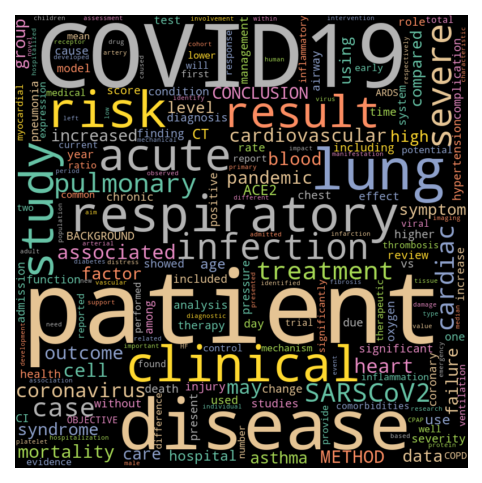

In [516]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create and generate a word cloud image:   
wordcloud = WordCloud(width = 800, height = 800, random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS).generate(text)

# Display the generated image:
# import matplotlib.pylab as plt
# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

You are now in good shape to define your recommendation function. These are the following steps you'll follow:

Get the index of the movie given its title.

Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position, and the second is the similarity score.

Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.

Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).

Return the titles corresponding to the indices of the top elements.

In [531]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = title
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    paper_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_citat['Title'].iloc[paper_indices]

In [533]:
n_title = 5
df_recommend = get_recommendations(n_title)  #df_citat['Title'].iloc[n_title])
df_recommend.to_csv('Recommend Papers.csv')

print('Content-Based Recommender - Top 10')
df_recommend

Content-Based Recommender - Top 10


2378    Venous Thromboembolism Has a Variable Time of ...
940                    Acute Ischemic Stroke and COVID-19
2573    MANIFESTATION OF COVID-19 IN THE FORM OF ACUTE...
2315    The effect of race on composite thrombotic eve...
1610    The Role of Anticoagulation in Post-COVID-19 C...
2309    A Review of Pathophysiology, Clinical Features...
2435    SARS-CoV-2 Receptors are Expressed on Human Pl...
2392    A Rare Presentation of Cerebrovascular Acciden...
340     Cardiovascular biomarkers in patients with COV...
2057    Forty-One-Year-Old Man with Pulmonary Embolism...
Name: Title, dtype: object

In [536]:
print(df_citat.columns.tolist())

['Publication ID', 'Title', 'Abstract', 'Authors', 'Authors Affiliations', 'Times Cited', 'Cited references', 'score']


In [537]:
df_citat['Authors'][1]

'Molin, Nicole L.; Molin, Clifford; Dalpatadu, Rohan J.; Singh, Ashok K.'

In [554]:
df_pub = df_citat[['Publication ID','Authors','Authors Affiliations','Cited references']].copy()

df_pub.to_csv('df_comments.csv')

#Replace NaN with an empty string
df_pub['Authors_2'] = df_pub['Authors'].fillna(';')
df_pub['Authors Affiliations_2'] = df_pub['Authors Affiliations'].fillna(';')
df_pub['Cited references_2'] = df_pub['Cited references'].fillna(';')
print(df_pub.shape)

df_pub = df_pub.drop(columns=(['Authors','Authors Affiliations','Cited references']))
print(df_pub.shape)
df_pub.columns=(['Publication ID','Authors','Authors Affiliations','Cited references'])

#Remove junk author
pub_list = ['pub.1134802587','pub.1134588066']
df_pub[~df_pub['Publication ID'].isin(pub_list)]

pub_list_in = ['pub.1129598070','pub.1129601032','pub.1135906085','pub.1136271880']
#df_pub = df_pub[df_pub['Publication ID'].isin(pub_list_in)]

df_pub = df_pub[0:500]
print(df_pub.shape)
df_pub

(2456, 7)
(2456, 4)
(500, 4)


,Publication ID,Authors,Authors Affiliations,Cited references
2561,pub.1133570250,"Woolf, Steven H.; Chapman, Derek A.; Lee, Jong...",Virginia Commonwealth University,"[Anderson, Robert N; Miniño, Arialdi M; Finger..."
557,pub.1135473658,"Shi, Feng; Xia, Liming; Shan, Fei; Song, Bin; ...",Tongji Hospital; Shanghai Public Health Clinic...,;
2647,pub.1133578173,"Koehler, Philipp; Bassetti, Matteo; Chakrabart...",University of Cologne; Cologne Excellence Clus...,"[Hiemenz, J. W.; Raad, I. I.; Maertens, J. A.;..."
2635,pub.1127843839,"Bostanciklioğlu, Mehmet",;,;
2451,pub.1133877031,"Mycroft-West, Courtney J; Su, Dunhao; Pagani, ...",Keele University; University of Liverpool; San...,"[Mousavi, Sarah; Moradi, Mandana; Khorshidahma..."
...,...,...,...,...
1553,pub.1134678992,"Abdullah, Muhammad; Khan, Khurshid; Javed, Mun...",University of Lahore; Lahore General Hospital,"[Ferrario, Carlos M.; Jessup, Jewell; Chappell..."
1552,pub.1134666967,"Page, Eden M; Ariëns, Robert A S",University of Leeds,"[Hess, Katharina; Ajjan, Ramzi; Phoenix, Fladi..."
1550,pub.1134661765,"Liu, Hangkuan; Wang, Zhijia; Sun, Haonan; Teng...",Tianjin Medical University; Tianjin Medical Un...,"[Franks, Teri J; Chong, Pek Y; Chui, Paul; Gal..."
1548,pub.1134688244,"Nunna, Krishidhar; Braun, Andrea Barbara",Baylor College of Medicine,"[Gupta, D; Hansell, A; Nichols, T; Duong, T; A..."


In [556]:
df_pub['Authors_Split'] = [list(x.split('; ')) for x in df_pub['Authors']]
df_pub.head()

,Publication ID,Authors,Authors Affiliations,Cited references,Authors_Split
2561,pub.1133570250,"Woolf, Steven H.; Chapman, Derek A.; Lee, Jong...",Virginia Commonwealth University,"[Anderson, Robert N; Miniño, Arialdi M; Finger...","[Woolf, Steven H., Chapman, Derek A., Lee, Jon..."
557,pub.1135473658,"Shi, Feng; Xia, Liming; Shan, Fei; Song, Bin; ...",Tongji Hospital; Shanghai Public Health Clinic...,;,"[Shi, Feng, Xia, Liming, Shan, Fei, Song, Bin,..."
2647,pub.1133578173,"Koehler, Philipp; Bassetti, Matteo; Chakrabart...",University of Cologne; Cologne Excellence Clus...,"[Hiemenz, J. W.; Raad, I. I.; Maertens, J. A.;...","[Koehler, Philipp, Bassetti, Matteo, Chakrabar..."
2635,pub.1127843839,"Bostanciklioğlu, Mehmet",;,;,"[Bostanciklioğlu, Mehmet]"
2451,pub.1133877031,"Mycroft-West, Courtney J; Su, Dunhao; Pagani, ...",Keele University; University of Liverpool; San...,"[Mousavi, Sarah; Moradi, Mandana; Khorshidahma...","[Mycroft-West, Courtney J, Su, Dunhao, Pagani,..."


In [568]:
# df_test['Authors_Split'].iloc[2]
df_split = df_pub[['Publication ID','Authors_Split']].copy()
df_split['Authors_Split']

2561    [Woolf, Steven H., Chapman, Derek A., Lee, Jon...
557     [Shi, Feng, Xia, Liming, Shan, Fei, Song, Bin,...
2647    [Koehler, Philipp, Bassetti, Matteo, Chakrabar...
2635                            [Bostanciklioğlu, Mehmet]
2451    [Mycroft-West, Courtney J, Su, Dunhao, Pagani,...
                              ...                        
1553    [Abdullah, Muhammad, Khan, Khurshid, Javed, Mu...
1552                   [Page, Eden M, Ariëns, Robert A S]
1550    [Liu, Hangkuan, Wang, Zhijia, Sun, Haonan, Ten...
1548           [Nunna, Krishidhar, Braun, Andrea Barbara]
1547    [Zadeh, Ehsan Safai, Beutel, Björn, Dietrich, ...
Name: Authors_Split, Length: 500, dtype: object

In [567]:
# Dataframe just of Pub-ID with Index 0-N rows
#df_pub.iloc[:,1].apply(pd.Series)
pd.DataFrame(df_split.iloc[:,1].values.tolist()).reset_index()

,index,0,1,2,3,4,5,6,7,8,...,391,392,393,394,395,396,397,398,399,400
0,0,"Woolf, Steven H.","Chapman, Derek A.","Lee, Jong Hyung",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1,"Shi, Feng","Xia, Liming","Shan, Fei","Song, Bin","Wu, Dijia","Wei, Ying","Yuan, Huan","Jiang, Huiting","He, Yichu",...,None,None,None,None,None,None,None,None,None,None
2,2,"Koehler, Philipp","Bassetti, Matteo","Chakrabarti, Arunaloke","Chen, Sharon C A","Colombo, Arnaldo Lopes","Hoenigl, Martin","Klimko, Nikolay","Lass-Flörl, Cornelia","Oladele, Rita O",...,None,None,None,None,None,None,None,None,None,None
3,3,"Bostanciklioğlu, Mehmet",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,4,"Mycroft-West, Courtney J","Su, Dunhao","Pagani, Isabel","Rudd, Timothy R","Elli, Stefano","Gandhi, Neha S","Guimond, Scott E","Miller, Gavin J","Meneghetti, Maria C Z",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,"Abdullah, Muhammad","Khan, Khurshid","Javed, Munaza","Iqbal, Javeid","Waheed, Khalid","Akhtar, Muhammad Naeem","Khan Chachar, Aijaz Zeeshan",None,None,...,None,None,None,None,None,None,None,None,None,None
496,496,"Page, Eden M","Ariëns, Robert A S",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
497,497,"Liu, Hangkuan","Wang, Zhijia","Sun, Haonan","Teng, Tianming","Li, Yongle","Zhou, Xin","Yang, Qing",None,None,...,None,None,None,None,None,None,None,None,None,None
498,498,"Nunna, Krishidhar","Braun, Andrea Barbara",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [579]:
# which group has the most number of co-authors
df_split['Authors_Split_Len'] = [len(x) for x in df_split['Authors_Split']]
df_split.sort_values('Authors_Split_Len', ascending=False)

,Publication ID,Authors_Split,Authors_Split_Len
2627,pub.1131399700,"[Drake, Thomas M., Docherty, Annemarie B., Har...",401
166,pub.1136003677,"[Bloom, Chloe I, Drake, Thomas M, Docherty, An...",343
1544,pub.1134713793,"[McManus, Richard J, Little, Paul, Stuart, Bet...",175
1785,pub.1134467953,"[Caro‐Codón, Juan, Rey, Juan R., Buño, Antonio...",47
1559,pub.1134661667,"[Suri, Jasjit S., Agarwal, Sushant, Gupta, Sun...",46
...,...,...,...
1904,pub.1134356974,[;],1
476,pub.1135668964,"[Edgoose, Jennifer Y C]",1
1504,pub.1134714737,[;],1
1965,pub.1134289782,"[Fadiran, Olusayo]",1


In [570]:
# Dataframe just of Pub-ID with Index 0-N rows
df_paper = pd.DataFrame(df_split.iloc[:,0].values.tolist()).reset_index()

# Dataframe just of Authors but converted to columns (across)
df_auth = df_split.iloc[:,1].apply(pd.Series).reset_index()  
df_auth
# Concat (join) dataframes based on Index (hopefully they match original Pub-ID and Author rows)
df_new = pd.concat([df_paper, df_auth], axis=1)
df_new = df_new.fillna('')

# remove 2nd index column
df_new.drop(df_new.iloc[:,2:3], inplace = True, axis = 1)
df_new = df_new.reset_index()

# create Pub-ID column name so can link back to original data
col_list = list(df_new.columns.values)
col_list

col_list[1] = 'Publication ID'
df_new.columns=[col_list]
print(col_list)

df_new

['index', 'Publication ID', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

,index,Publication ID,0,1,2,3,4,5,6,7,...,391,392,393,394,395,396,397,398,399,400
0,0,pub.1133570250,"Woolf, Steven H.","Chapman, Derek A.","Lee, Jong Hyung",,,,,,...,,,,,,,,,,
1,1,pub.1135473658,"Shi, Feng","Xia, Liming","Shan, Fei","Song, Bin","Wu, Dijia","Wei, Ying","Yuan, Huan","Jiang, Huiting",...,,,,,,,,,,
2,2,pub.1133578173,"Koehler, Philipp","Bassetti, Matteo","Chakrabarti, Arunaloke","Chen, Sharon C A","Colombo, Arnaldo Lopes","Hoenigl, Martin","Klimko, Nikolay","Lass-Flörl, Cornelia",...,,,,,,,,,,
3,3,pub.1127843839,"Bostanciklioğlu, Mehmet",,,,,,,,...,,,,,,,,,,
4,4,pub.1133877031,"Mycroft-West, Courtney J","Su, Dunhao","Pagani, Isabel","Rudd, Timothy R","Elli, Stefano","Gandhi, Neha S","Guimond, Scott E","Miller, Gavin J",...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,pub.1134678992,"Abdullah, Muhammad","Khan, Khurshid","Javed, Munaza","Iqbal, Javeid","Waheed, Khalid","Akhtar, Muhammad Naeem","Khan Chachar, Aijaz Zeeshan",,...,,,,,,,,,,
496,496,pub.1134666967,"Page, Eden M","Ariëns, Robert A S",,,,,,,...,,,,,,,,,,
497,497,pub.1134661765,"Liu, Hangkuan","Wang, Zhijia","Sun, Haonan","Teng, Tianming","Li, Yongle","Zhou, Xin","Yang, Qing",,...,,,,,,,,,,
498,498,pub.1134688244,"Nunna, Krishidhar","Braun, Andrea Barbara",,,,,,,...,,,,,,,,,,


In [630]:
# iterate across all author columns, append them after each other, final concat for all appended dataframes
all_auth = []
new_list = ['index','Publication ID','Authors']
for col in col_list[2:]:
    df_app = []
    df_app = df_new[['index','Publication ID',col]].copy()
    df_app.columns = new_list
    all_auth.append(df_app)

df_pub_auth = pd.concat(all_auth)
print('len pub-auth all rows         ',df_pub_auth.shape)

# remove rows with blank Authors
df_pub_auth = df_pub_auth[df_pub_auth['Authors']!='']  
df_pub_auth = df_pub_auth[df_pub_auth['Authors']!=';']  
print('len pub-auth del blank Authors',df_pub_auth.shape)

# get number of co-authors per paper, for node size of paper
df_size = df_pub_auth.groupby(['index','Publication ID']).count().reset_index().sort_values('Authors', ascending=False)
df_size = df_size[['index','Authors']]
df_size.columns=(['index','Author_Size'])

# combine to main data
df_pub_auth = df_pub_auth.join(df_size.set_index('index'), on='index')
df_pub_auth

# save output for viewing
df_pub_auth.to_csv('sina_pub_authors.csv')

df_pub_auth

len pub-auth all rows          (200500, 3)
len pub-auth del blank Authors (4851, 3)


,index,Publication ID,Authors,Author_Size
0,0,pub.1133570250,"Woolf, Steven H.",3
1,1,pub.1135473658,"Shi, Feng",12
2,2,pub.1133578173,"Koehler, Philipp",36
3,3,pub.1127843839,"Bostanciklioğlu, Mehmet",1
4,4,pub.1133877031,"Mycroft-West, Courtney J",25
...,...,...,...,...
8,8,pub.1131399700,"Wolverson, Adam",401
8,8,pub.1131399700,"Wooton, Daniel G.",401
8,8,pub.1131399700,"Workman, Andrew",401
8,8,pub.1131399700,"Yates, Bryan",401


In [622]:
# Create node list with ID's
df_node_pub = df_new[['index','Publication ID']].copy()
df_node_pub['node_group']='Paper'
df_node_pub.columns=(['node_id','node_name','node_group'])
df_node_pub

,node_id,node_name,node_group
0,0,pub.1133570250,Paper
1,1,pub.1135473658,Paper
2,2,pub.1133578173,Paper
3,3,pub.1127843839,Paper
4,4,pub.1133877031,Paper
...,...,...,...
495,495,pub.1134678992,Paper
496,496,pub.1134666967,Paper
497,497,pub.1134661765,Paper
498,498,pub.1134688244,Paper


In [618]:
df_pub_auth[df_pub_auth['Publication ID']=='pub.1133570250']

,index,Publication ID,Authors,author_size
0,0,pub.1133570250,"Woolf, Steven H.",3
0,0,pub.1133570250,"Chapman, Derek A.",3
0,0,pub.1133570250,"Lee, Jong Hyung",3


In [631]:
# create Author nodes - assume Author with same name, is same Author - which is not true in real life
# but can't differentiate with this current data
# create index value - we will assign to the nodes & edge relationships
df_node_author = df_pub_auth[['Authors']].groupby('Authors').count().reset_index().reset_index()
df_node_author.columns=(['Author_ID','Authors'])

# combine Published-Author + Author-ID
df_pub_auth = df_pub_auth.join(df_nodes.set_index('Authors'), on='Authors')

df_pub_auth

,index,Publication ID,Authors,Author_Size,Author_ID
0,0,pub.1133570250,"Woolf, Steven H.",3,4172
1,1,pub.1135473658,"Shi, Feng",12,3535
2,2,pub.1133578173,"Koehler, Philipp",36,1989
3,3,pub.1127843839,"Bostanciklioğlu, Mehmet",1,465
4,4,pub.1133877031,"Mycroft-West, Courtney J",25,2722
...,...,...,...,...,...
8,8,pub.1131399700,"Wolverson, Adam",401,4163
8,8,pub.1131399700,"Wooton, Daniel G.",401,4174
8,8,pub.1131399700,"Workman, Andrew",401,4175
8,8,pub.1131399700,"Yates, Bryan",401,4245


In [609]:
# check correct ID & Author
df_nodes[df_nodes['Author_ID']==4172]

,Author_ID,Authors
4172,4172,"Woolf, Steven H."


In [632]:
# finish creating nodes for Author
df_node_author['node_group']='Author'
df_node_author.columns=(['node_id','node_name','node_group'])
df_node_author

,node_id,node_name,node_group
0,0,"AL Jorge, D Palmero",Author
1,1,"Abbasi, Madineh",Author
2,2,"Abbott, Robert",Author
3,3,"Abdeen, Yazan",Author
4,4,"Abdel-Alrahman, Gamal",Author
...,...,...,...
4408,4408,"von der Thusen, Jan H",Author
4409,4409,"zur-Wiesch, Julian Schulze",Author
4410,4410,"Álvarez, Daniel",Author
4411,4411,"Özkan, Mehmet",Author


In [639]:
#df_pub_auth = pd.concat([df_node_author,df_node_author])
test = pd.concat([df_node_pub,df_node_author]).reset_index()

# check rows are the same - end of Pub list, start of Author list - matching above lists
test[497:504]

,index,node_id,node_name,node_group
497,497,497,pub.1134661765,Paper
498,498,498,pub.1134688244,Paper
499,499,499,pub.1134668610,Paper
500,0,0,"AL Jorge, D Palmero",Author
501,1,1,"Abbasi, Madineh",Author
502,2,2,"Abbott, Robert",Author
503,3,3,"Abdeen, Yazan",Author


In [645]:
# check rows are the same - start of Pub list, end of Author list - matching above lists
test[['node_id','node_name','node_group']]

,node_id,node_name,node_group
0,0,pub.1133570250,Paper
1,1,pub.1135473658,Paper
2,2,pub.1133578173,Paper
3,3,pub.1127843839,Paper
4,4,pub.1133877031,Paper
...,...,...,...
4908,4408,"von der Thusen, Jan H",Author
4909,4409,"zur-Wiesch, Julian Schulze",Author
4910,4410,"Álvarez, Daniel",Author
4911,4411,"Özkan, Mehmet",Author
